In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

In [27]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

from SepMe.ml.vis import plot_corr_matrix, resize_and_save, get_grid, scat_of_scat, grid_scat
from SepMe.ml.agg import (reshape_sepme, pivot_sepme,reshape_humandf,append_expertdf, 
                          add_interval,aggregate)

from sklearn.model_selection import train_test_split
import scipy.spatial

print(os.getcwd())

sepme_path = '../../data/mturk_samples/phase1/graph_results/res_mturk_batch.csv'
res_path = '../all.csv'

dataset_path = '../data/mturk_samples/phase1/data/'
expert_path = '../../data/orig_data/human_reduced_results.csv'


sepmes = ['as_0.02_ce', 'as_0.02_cp',
       'as_0.02_ltcc', 'as_0.05_ce', 'as_0.05_cp', 'as_0.05_ltcc', 'as_0.1_ce',
       'as_0.1_cp', 'as_0.1_ltcc', 'as_0.5_ce', 'as_0.5_cp', 'as_0.5_ltcc',
       'bt_0.02_cp', 'bt_0.02_ltcc',  'bt_0.05_cp',
       'bt_0.05_ltcc', 'bt_0.1_cp', 'bt_0.1_ltcc', 'bt_0.5_ce',
       'bt_0.5_cp', 'bt_0.5_ltcc', 'cbsg_0.1_ce', 'cbsg_0.1_cp',
       'cbsg_0.1_ltcc', 'cbsg_0.2_ce', 'cbsg_0.2_cp', 'cbsg_0.2_ltcc',
       'cbsg_0.5_ce', 'cbsg_0.5_cp', 'cbsg_0.5_ltcc', 'cbsg_2.0_ce',
       'cbsg_2.0_cp', 'cbsg_2.0_ltcc', 'del_n/a_ce', 'del_n/a_cp',
       'del_n/a_ltcc', 'del_n/a_mv_false', 'del_n/a_mv_true', 'knn_1.0_ce',
       'knn_1.0_cp', 'knn_1.0_ltcc', 'knn_2.0_ce', 'knn_2.0_cp',
       'knn_2.0_ltcc', 'knn_4.0_ce', 'knn_4.0_cp', 'knn_4.0_ltcc',
       'knn_6.0_ce', 'knn_6.0_cp', 'knn_6.0_ltcc', 'knn_8.0_ce', 'knn_8.0_cp',
       'knn_8.0_ltcc']

/Users/morarica/Developer/SepMe/Jupyters/ml


In [28]:
df_sep = pivot_sepme(reshape_sepme(sepme_path))
#plot_corr_matrix(df, (5,5))


df_hums = append_expertdf(reshape_humandf(res_path, 
                                      ['filename', 'type', '1v1', 'phase', 'WorkerId', 'SubmitTime'],
                                      drop=True), 
                      expert_path)

df = df_hums.merge(df_sep, on='idx').drop(['idx'],axis=1)


df = add_interval(df, intervals=[0, .33, .66, 1.00], 
                  col_name='interval_3', target_interval='human_rating')
df = add_interval(df, intervals=[0, .25, .5, .75, 1.00], 
                  col_name='interval_5', target_interval='human_rating')

df = add_interval(df, intervals=np.arange(0,1,.1), 
                  col_name='interval_10', target_interval='human_rating')

df.to_csv('df_clean.csv', index=False)



(130, 1276)


/Users/morarica/miniconda3/envs/SepMe/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [29]:
df.loc[df['filename']=='yeast_PCA',['filename','class','type',
        'WorkerId','human_rating',
        'expert_name','expert_rating','as_0.02_cp']].groupby(['filename','class','type']).mean()

human_rating  expert_rating  as_0.02_cp
filename  class type                                             
yeast_PCA 1     abstract      0.136786              1    0.314211
                semantic      0.483750              1    0.314211
          2     abstract      0.172963              1    0.292218
                semantic      0.436250              1    0.292218
          3     abstract      0.152000              1    0.340774
                semantic      0.481250              1    0.340774
          4     abstract      0.176562              1    0.354436
                semantic      0.285000              1    0.354436

In [138]:
df_agg = aggregate(df, by =['filename', 'type', 'class'])


df_agg = add_interval(df_agg, intervals=[0, .33, .66, 1.00], 
                  col_name='interval_3')

df_agg = add_interval(df_agg, intervals=[0, .2, .4, .6, .8, 1.00], 
                  col_name='interval_5')

df_agg = add_interval(df_agg, intervals=np.arange(0,1,.1), 
                  col_name='interval_10')


df_agg.to_csv('df_agg.csv', index=False)


df_agg = df_agg.sort_values(['filename'])

print(df_agg.columns)


train, test= train_test_split(df_agg, test_size = 0.2,random_state = 42, shuffle = False)
print(set(train.index).intersection(set(test.index)))


n = 5
pca = PCA(n_components=n)
iso = TSNE(n_components=2, n_jobs=-1, perplexity=55, learning_rate=20)

pca.fit(df_agg.loc[train.index, sepmes])
pca_vals = pca.fit_transform(df_agg[sepmes])
iso_vals = iso.fit_transform(df_agg[sepmes])

print(pca.explained_variance_ratio_)

for i in range(1,n+1):
    df_agg['PCA_{}'.format(i)] = -pca_vals[:, i-1]
    if i<=2:
        df_agg['TSNE_{}'.format(i)] = iso_vals[:, i-1]
    

df_agg = df_agg.drop(sepmes, axis=1)
df_agg['expert_rating.cat'] = ['sep_level_' + str(row) for i,row in df_agg['expert_rating.first'].items()]


df_agg['expert_consensus'] = np.abs(df_agg['expert_rating.first'] - df_agg['expert_rating.last'])
df_agg['expert_consensus'] = ['discrepancy_of_' + str(row) for i,row in df_agg['expert_consensus'].items()]


df_agg.to_csv('df_dr.csv', index=False)

#df_agg['spread'] = np.round(df_agg['spread']*100)
#df_agg['spread'] = df_agg['spread'].astype(int)
print(df_agg.columns)

Index(['filename', 'type', 'class', 'human_rating.mean', 'human_rating.count',
       'human_rating.sem', 'expert_rating.first', 'expert_rating.last',
       'expert_rating.mean', 'human_rating', 'expert_rating', 'as_0.02_ce',
       'as_0.02_cp', 'as_0.02_ltcc', 'as_0.05_ce', 'as_0.05_cp',
       'as_0.05_ltcc', 'as_0.1_ce', 'as_0.1_cp', 'as_0.1_ltcc', 'as_0.5_ce',
       'as_0.5_cp', 'as_0.5_ltcc', 'bt_0.02_cp', 'bt_0.02_ltcc', 'bt_0.05_cp',
       'bt_0.05_ltcc', 'bt_0.1_cp', 'bt_0.1_ltcc', 'bt_0.5_ce', 'bt_0.5_cp',
       'bt_0.5_ltcc', 'cbsg_0.1_ce', 'cbsg_0.1_cp', 'cbsg_0.1_ltcc',
       'cbsg_0.2_ce', 'cbsg_0.2_cp', 'cbsg_0.2_ltcc', 'cbsg_0.5_ce',
       'cbsg_0.5_cp', 'cbsg_0.5_ltcc', 'cbsg_2.0_ce', 'cbsg_2.0_cp',
       'cbsg_2.0_ltcc', 'del_n/a_ce', 'del_n/a_cp', 'del_n/a_ltcc',
       'del_n/a_mv_false', 'del_n/a_mv_true', 'knn_1.0_ce', 'knn_1.0_cp',
       'knn_1.0_ltcc', 'knn_2.0_ce', 'knn_2.0_cp', 'knn_2.0_ltcc',
       'knn_4.0_ce', 'knn_4.0_cp', 'knn_4.0_ltcc', 'knn_6.0

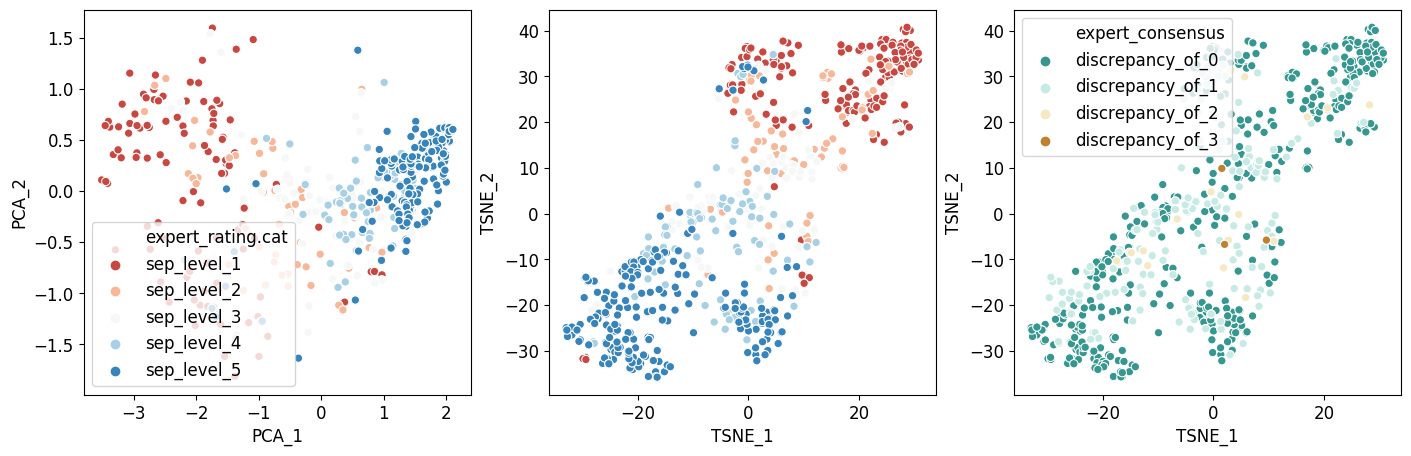

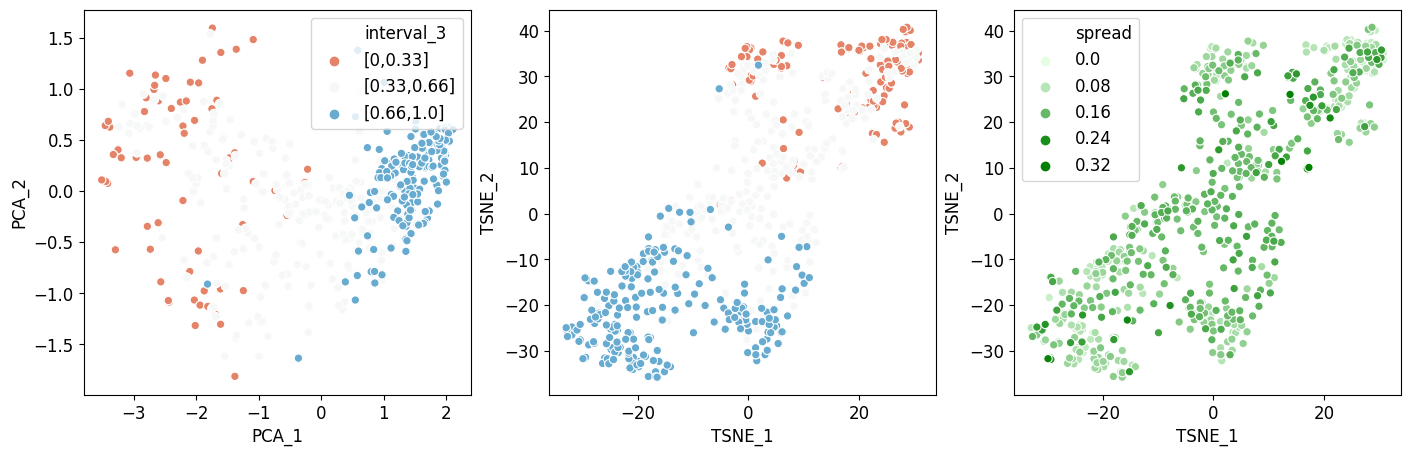

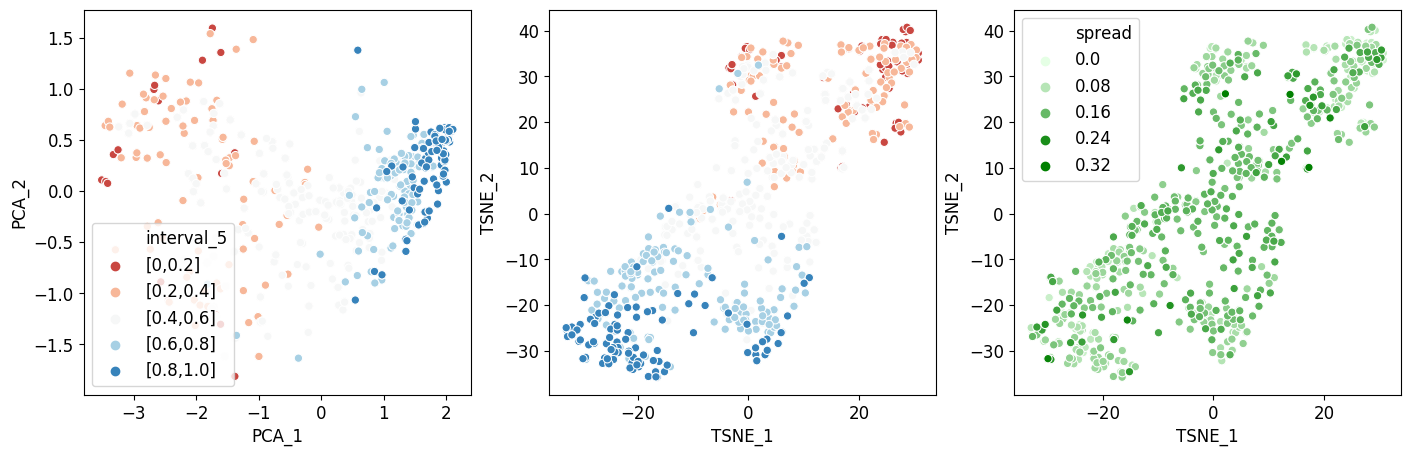

In [134]:
for color_col in ['expert_rating.cat', 'interval_3', 'interval_5']:
    df_agg = df_agg.sort_values([color_col])
    fig, ax = plt.subplots(1,3, figsize=(17,5))
    n = len(set(df_agg[color_col]))
    
    sns.scatterplot(x="PCA_1", y="PCA_2", hue = color_col, 
                    data=df_agg, palette=sns.color_palette("RdBu", n), ax=ax[0])
    sns.scatterplot(x="TSNE_1", y="TSNE_2", hue = color_col, 
                    data=df_agg, palette=sns.color_palette("RdBu", n), ax=ax[1])
    
    ax[1].get_legend().remove()
    
    
    if color_col.startswith('expert'):
        check_col = 'expert_consensus'
        m = len(set(df_agg[check_col]))
        pal= sns.color_palette("BrBG_r", m)
    else:
        check_col = 'spread'
        pal= sns.light_palette("green", as_cmap=True)
    
    df_agg = df_agg.sort_values([check_col])
   

    
    sns.scatterplot(x="TSNE_1", y="TSNE_2", hue = check_col, 
                    data=df_agg, palette=pal, ax=ax[2])
    


In [135]:
df_agg_abs = df_agg.loc[(df_agg['type']=='abstract')]
dd = df_agg_abs.groupby(['filename']).agg({'human_rating.mean':['mean'], 
                                      'expert_rating.first':['first', 'mean']})

dd.columns = ["%s%s" % (a.split('.')[0], ".%s" % b if b else "") for a, b in dd.columns]
dd = dd.reset_index()
dd['m'] = dd['expert_rating.first'] - dd['expert_rating.mean']
dd['merge']=0
dd.loc[dd['m'].between(-.1,.1),'merge']=1
dd= dd.drop(['expert_rating.first','expert_rating.mean', 'human_rating.mean','m'], axis=1)
df_agg_abs = df_agg_abs.merge(dd, on='filename')


baby_path = '../../data/mturk_samples/task/baby_figs_1v1/'
big_path = '../../data/mturk_samples/task/baby_figs/'


paths=[]
for i,row in df_agg_abs.iterrows():
    if row['merge']==0:
        paths.append(baby_path + row['filename'] +'_1-2_'+ str(int(row['class']-1))+ '.png')

    else:
        if row['class']==1:
            paths.append(big_path + row['filename'] + '.png')
        else:
            paths.append('')


df_agg_abs['path'] = paths
df_agg_abs = df_agg_abs.loc[df_agg_abs['path']!='']
df_agg_abs

filename      type  class  \
0                                   swanson_GlimmerMDS  abstract      1   
5                  ms_interleaved_400_800_3d_50_RobPCA  abstract      1   
6                              cars03Cropped_d3_RobPCA  abstract      2   
7                              cars03Cropped_d3_RobPCA  abstract      4   
8                              cars03Cropped_d3_RobPCA  abstract      3   
..                                                 ...       ...    ...   
439                                     world_11d_tSNE  abstract      2   
440                        n100-d5-c3-spr0.2-out0_tSNE  abstract      3   
441                        n100-d5-c3-spr0.2-out0_tSNE  abstract      2   
442                        n100-d5-c3-spr0.2-out0_tSNE  abstract      1   
444  ms_interleaved_60_120_3d_50_centeredClusters_R...  abstract      1   

     human_rating.mean  human_rating.count  human_rating.sem  \
0             0.040714                  28          0.007363   
5             0.095333                  30          0.022416   
6             0.080000                  60          0.010056   
7             0.083226                  62          0.011333   
8             0.120571                  70          0.015672   
..                 ...                 ...               ...   
439           0.492500                  40          0.046522   
440           0.524000                  40          0.039563   
441           0.442500                  40          0.041293   
442           0.521000                  40          0.042520   
444           0.422000                  40          0.046816   

     expert_rating.first  expert_rating.last  expert_rating.mean  \
0                      1                   1                 1.0   
5                      2                   2                 2.0   
6                      1                   1                 1.0   
7                      2                   2                 2.0   
8                      1                   1                 1.0   
..                   ...                 ...                 ...   
439                    2                   3                 2.5   
440                    1                   4                 2.5   
441                    2                   3                 2.5   
442                    2                   4                 3.0   
444                    2                   3                 2.5   

     human_rating  ...     TSNE_1     PCA_2     TSNE_2     PCA_3     PCA_4  \
0        0.040714  ...  28.725552  0.094200  40.757599  0.396232  0.517991   
5        0.095333  ...  13.554036  0.072685  29.742077  0.481184  0.062938   
6        0.080000  ...  16.244204  0.374775  22.920460  0.422773  0.465935   
7        0.083226  ...  25.436691  1.035277  32.233929  0.024581  0.452209   
8        0.120571  ...  24.805447  0.994732  31.830507  0.027143  0.448153   
..            ...  ...        ...       ...        ...       ...       ...   
439      0.492500  ...   3.672547 -0.755144  -2.664141 -0.029693 -0.069666   
440      0.524000  ...   9.596905 -1.086672  -5.785429 -0.254206  0.090709   
441      0.442500  ...  10.592793 -0.924085  -2.084729 -0.289513  0.278247   
442      0.521000  ...  10.833048 -1.163480  -6.086532 -0.424388  0.083638   
444      0.422000  ...   4.143367 -0.547414  18.087448 -0.159363 -0.007637   

        PCA_5 expert_rating.cat  expert_consensus  merge  \
0    0.440776       sep_level_1  discrepancy_of_0      1   
5    0.530396       sep_level_2  discrepancy_of_0      1   
6    0.113056       sep_level_1  discrepancy_of_0      0   
7   -0.035027       sep_level_2  discrepancy_of_0      0   
8    0.013118       sep_level_1  discrepancy_of_0      0   
..        ...               ...               ...    ...   
439  0.207299       sep_level_2  discrepancy_of_1      0   
440  0.179555       sep_level_1  discrepancy_of_3      0   
441  0.269483       sep_level_2  discrepancy_of_1      0   
442  0.048737       se

0
100
200
300


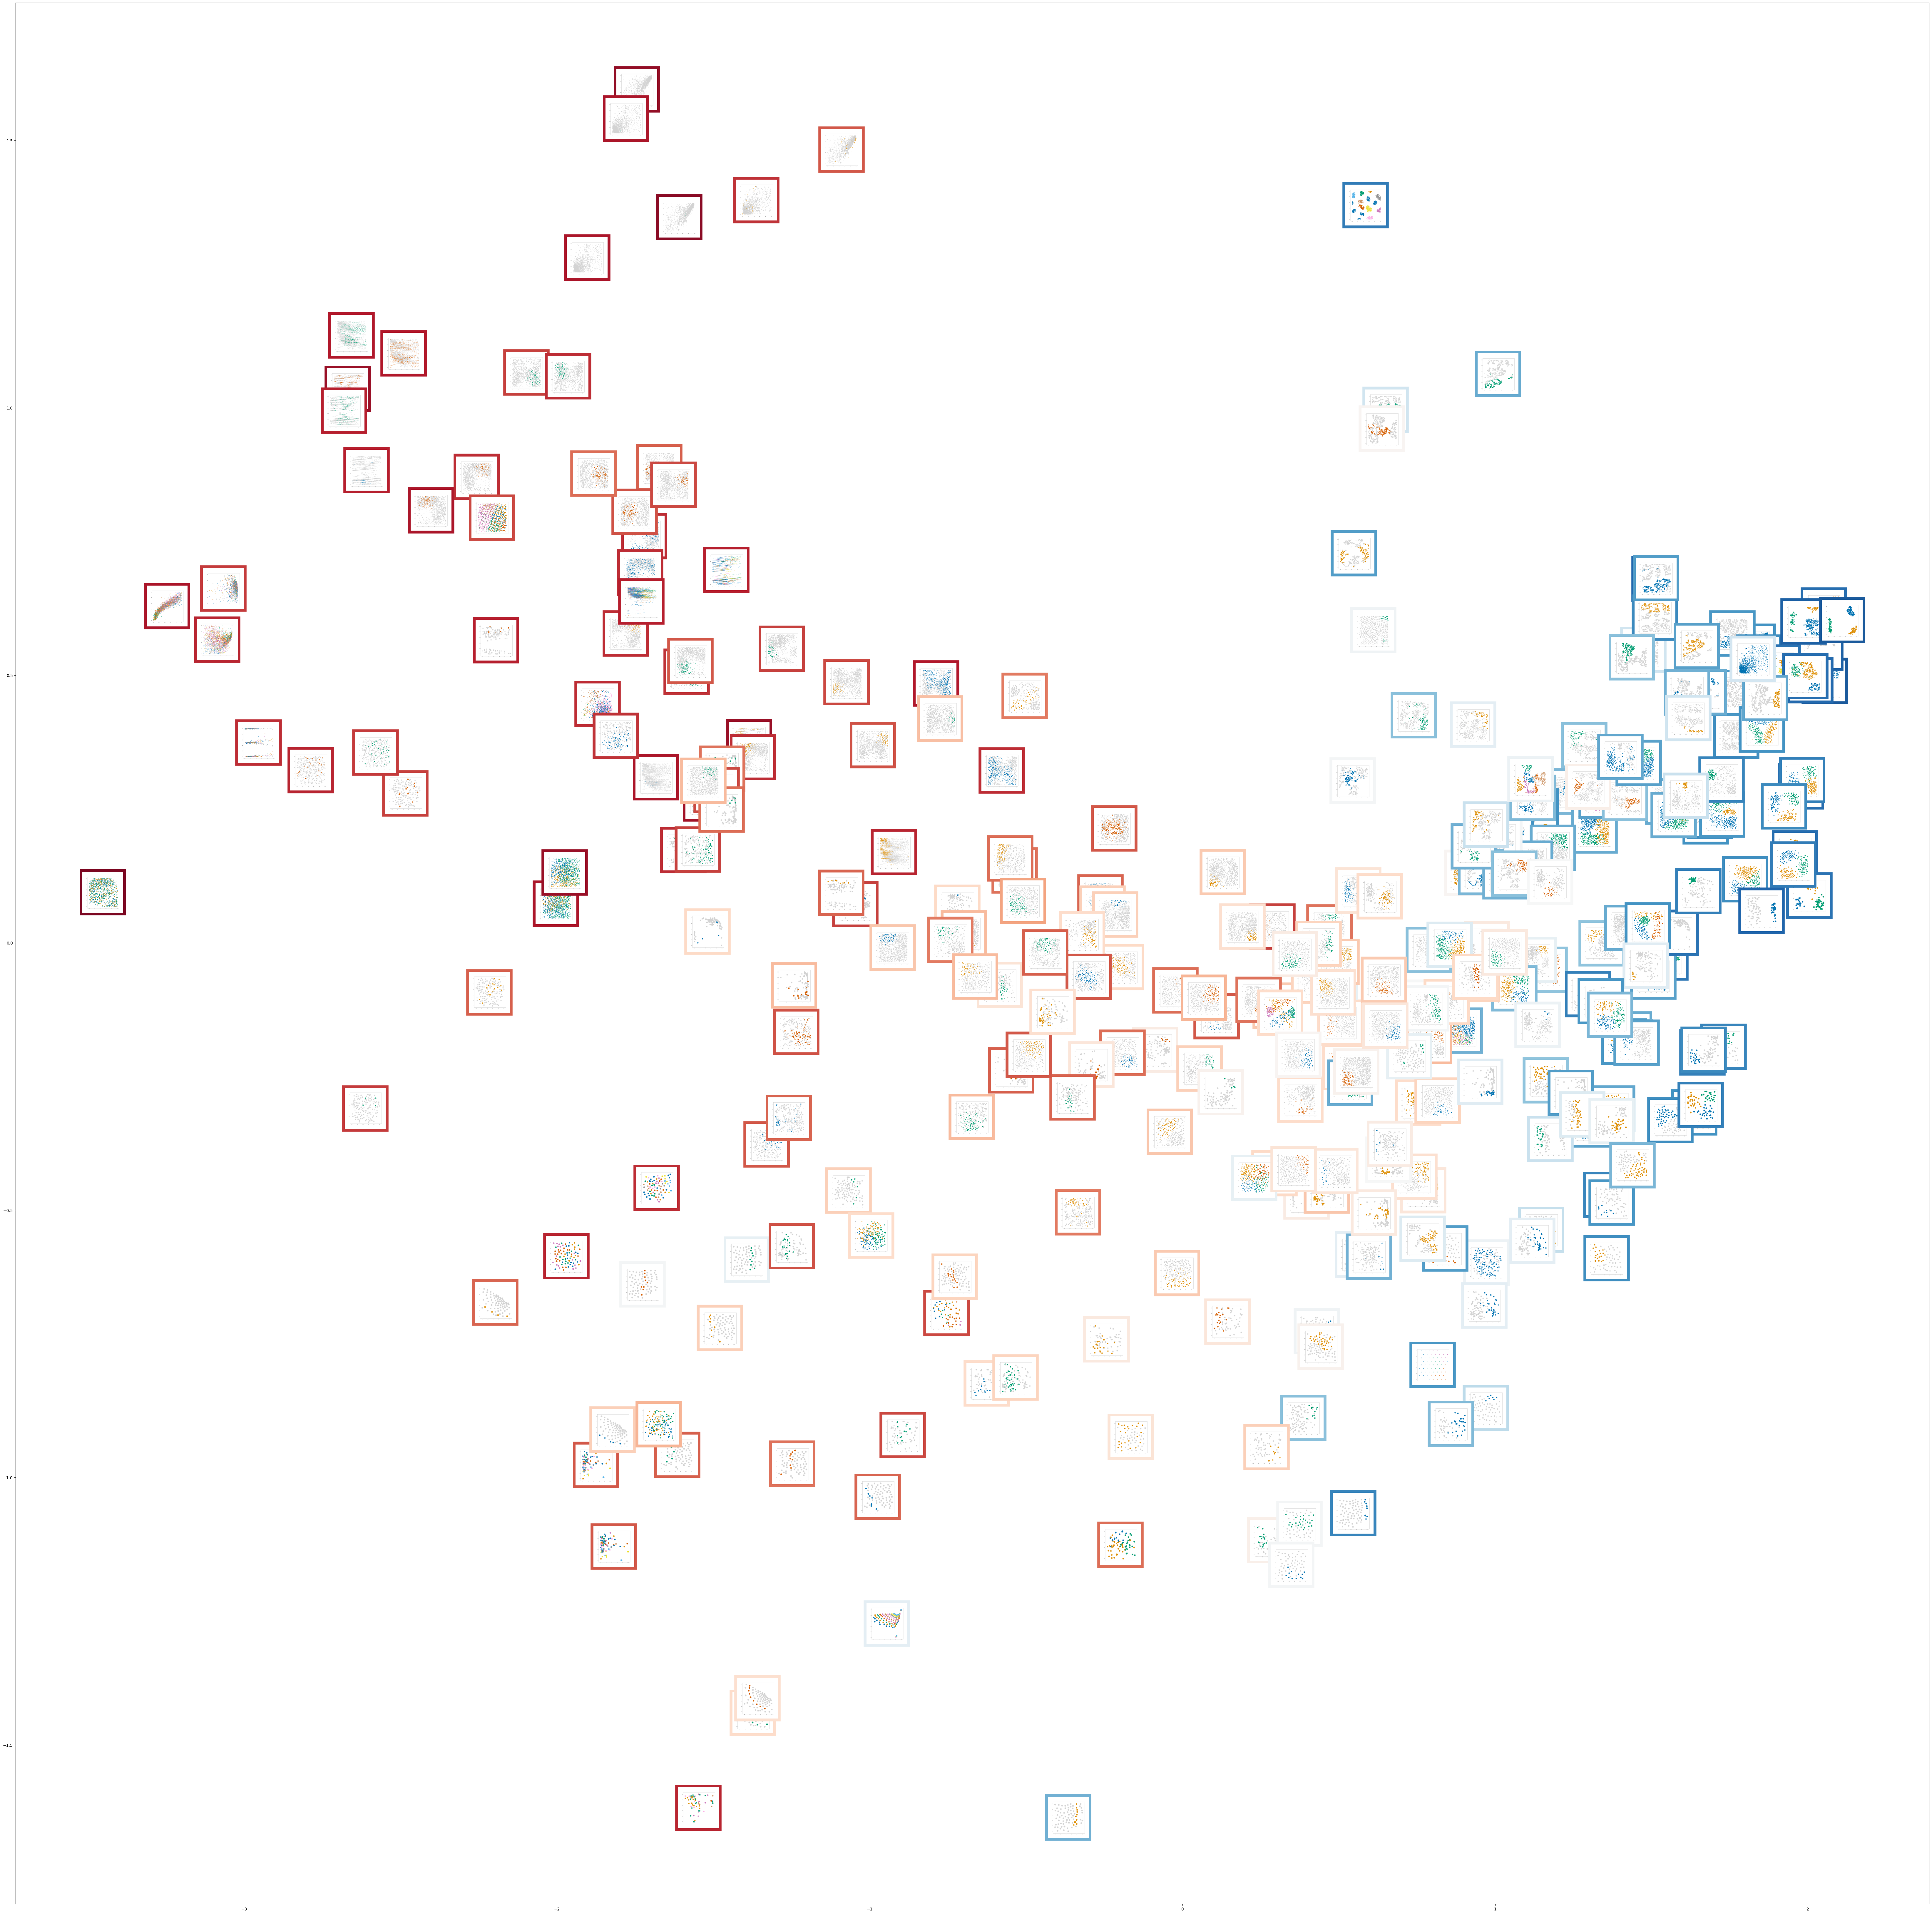

In [136]:
plt.style.use('default')
figsize=(84,84)

scat_of_scat(list(df_agg_abs['PCA_1']), list(df_agg_abs['PCA_2']), df_agg_abs['path'],
             colors=np.round(df_agg_abs['human_rating.mean']*100),
             figsize=figsize)   
 


4.0
93.0
0
100


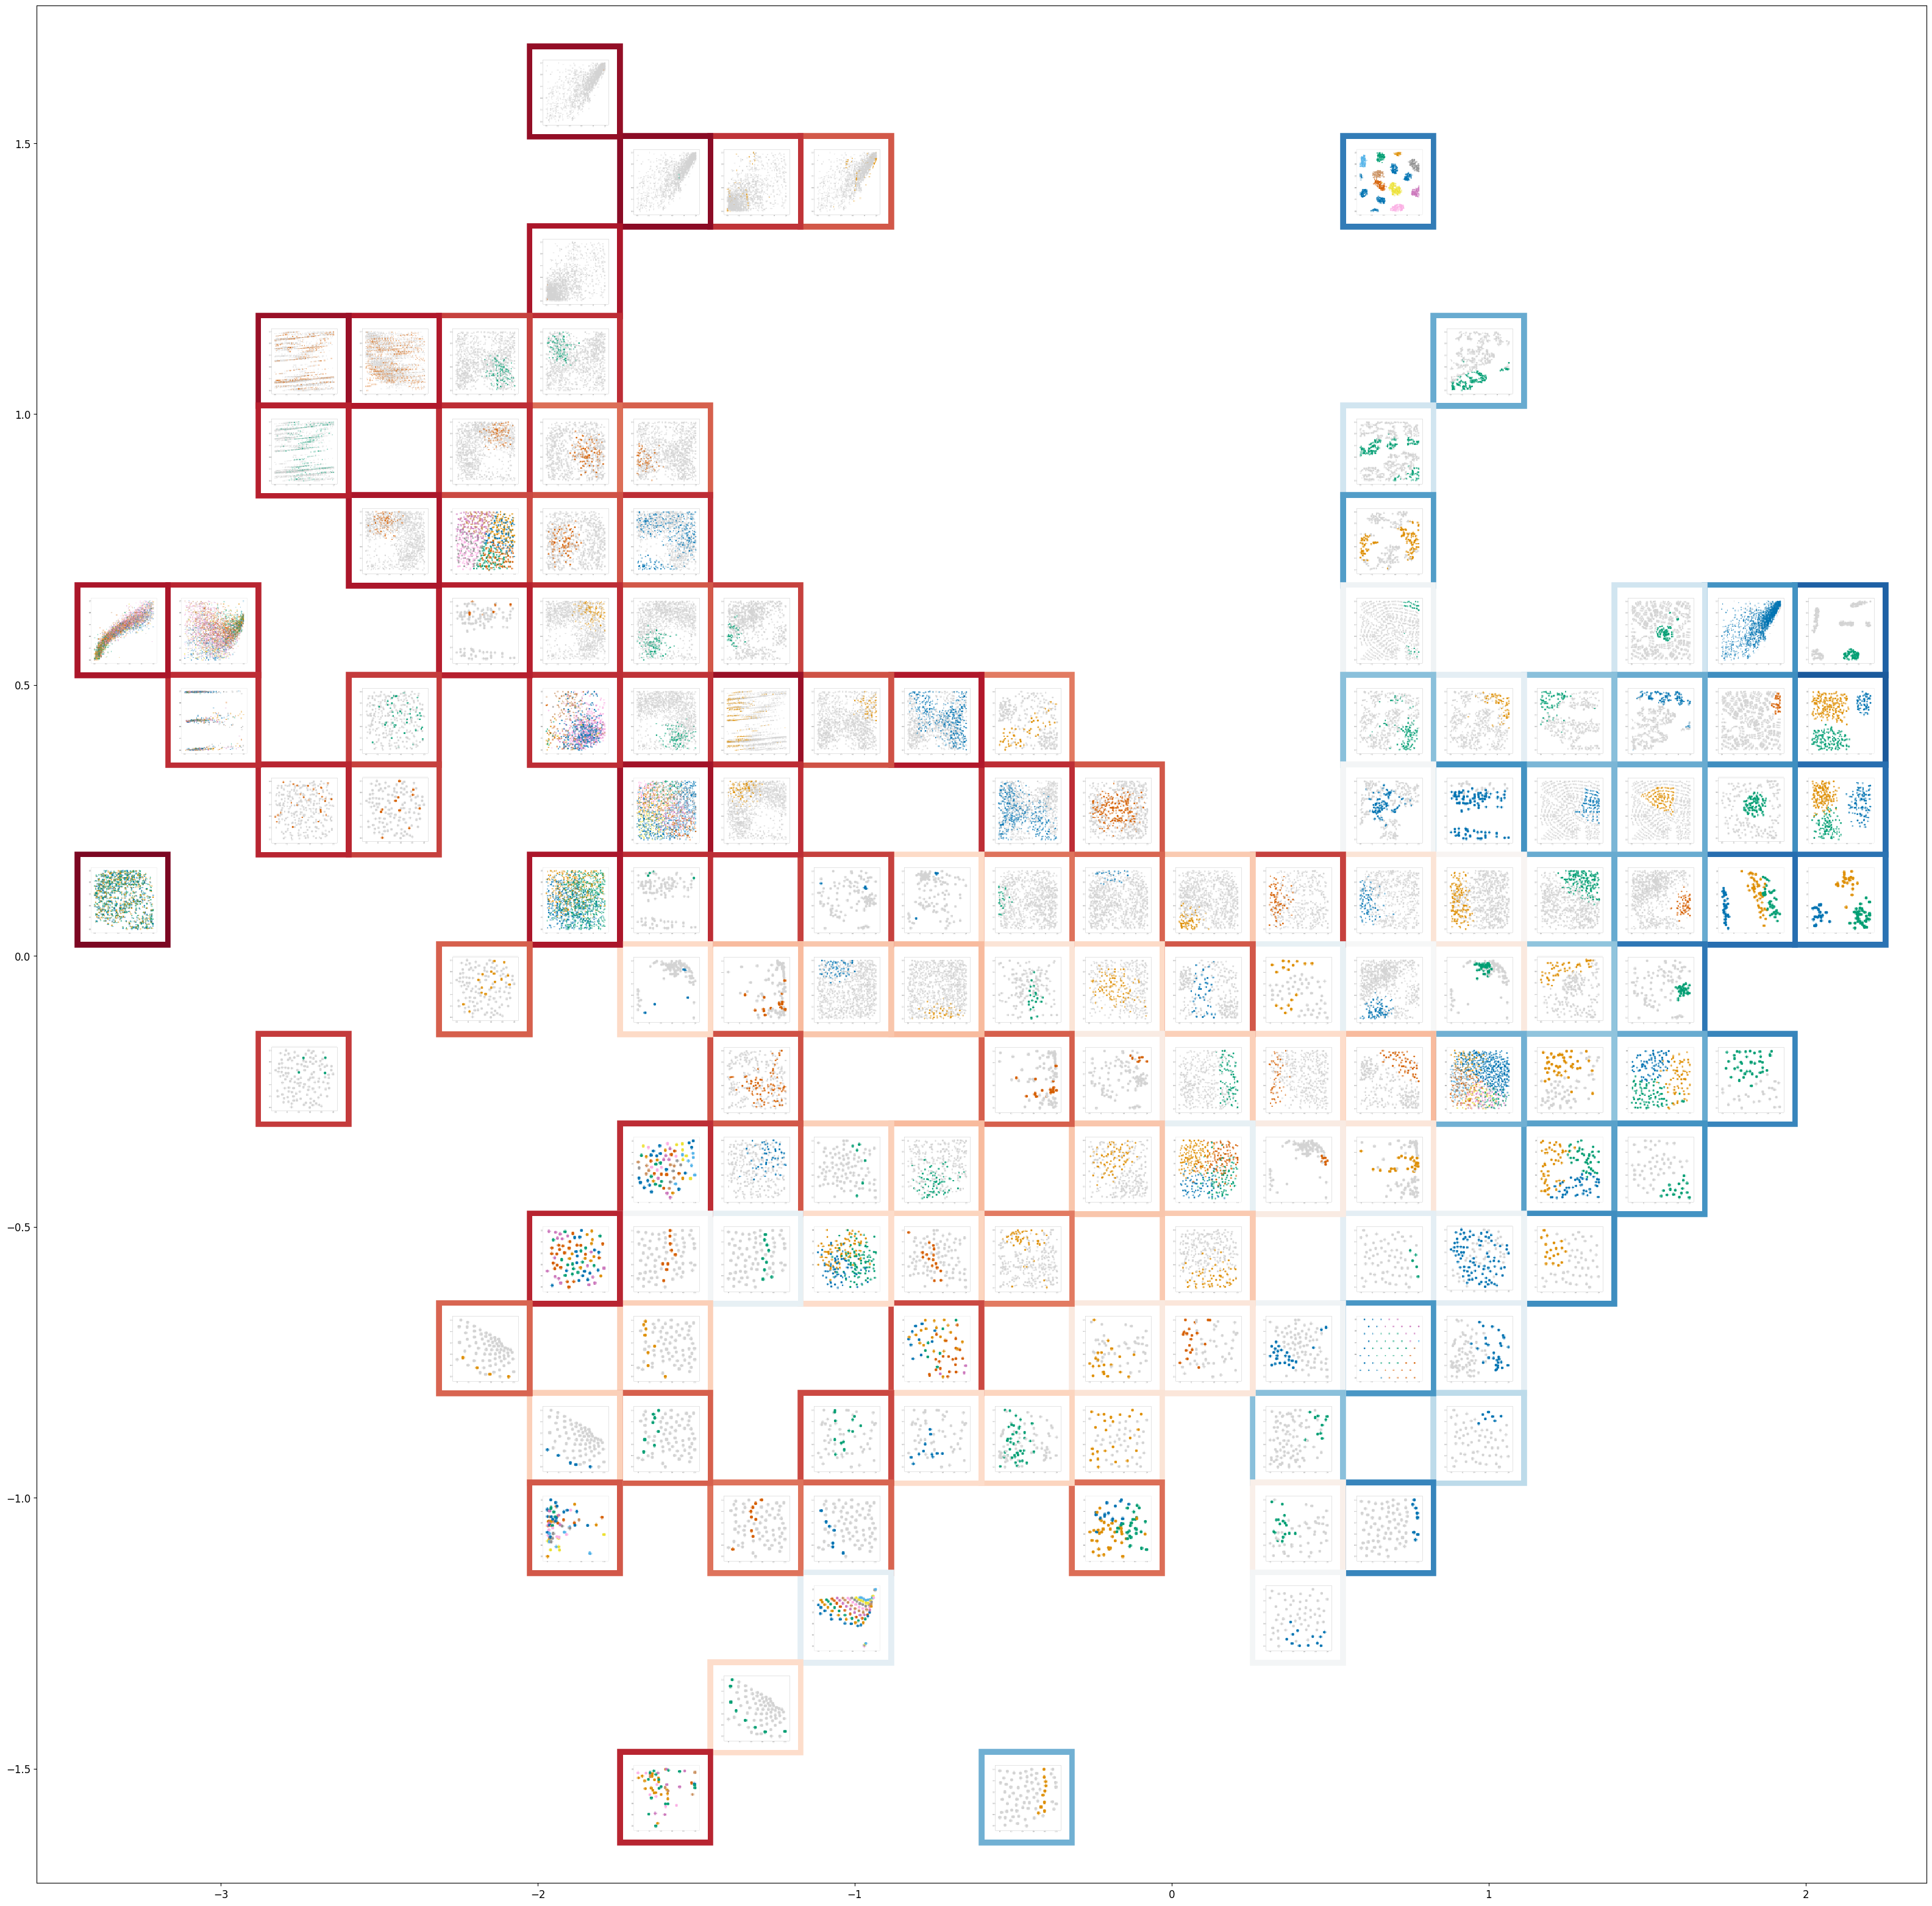

In [185]:
df1 = grid_scat(df_agg_abs['PCA_1'], df_agg_abs['PCA_2'], df_agg_abs, hue = 'human_rating.mean',
                name ='scatter_PCA_grid_small.pdf',figsize=(40,40), 
                size_x=20, size_y=20,n=0,steps = 10)



# df1 = grid_scat(df_agg_abs['TSNE_1'], df_agg_abs['TSNE_2'], 
#                 df_agg_abs, hue = 'human_rating.mean',
#                 name ='scatter_TSNE_grid_small.pdf',figsize=(40,40), 
#                 size_x=20, size_y=20,n=0)




(306, 31)
9.0
90.0
0


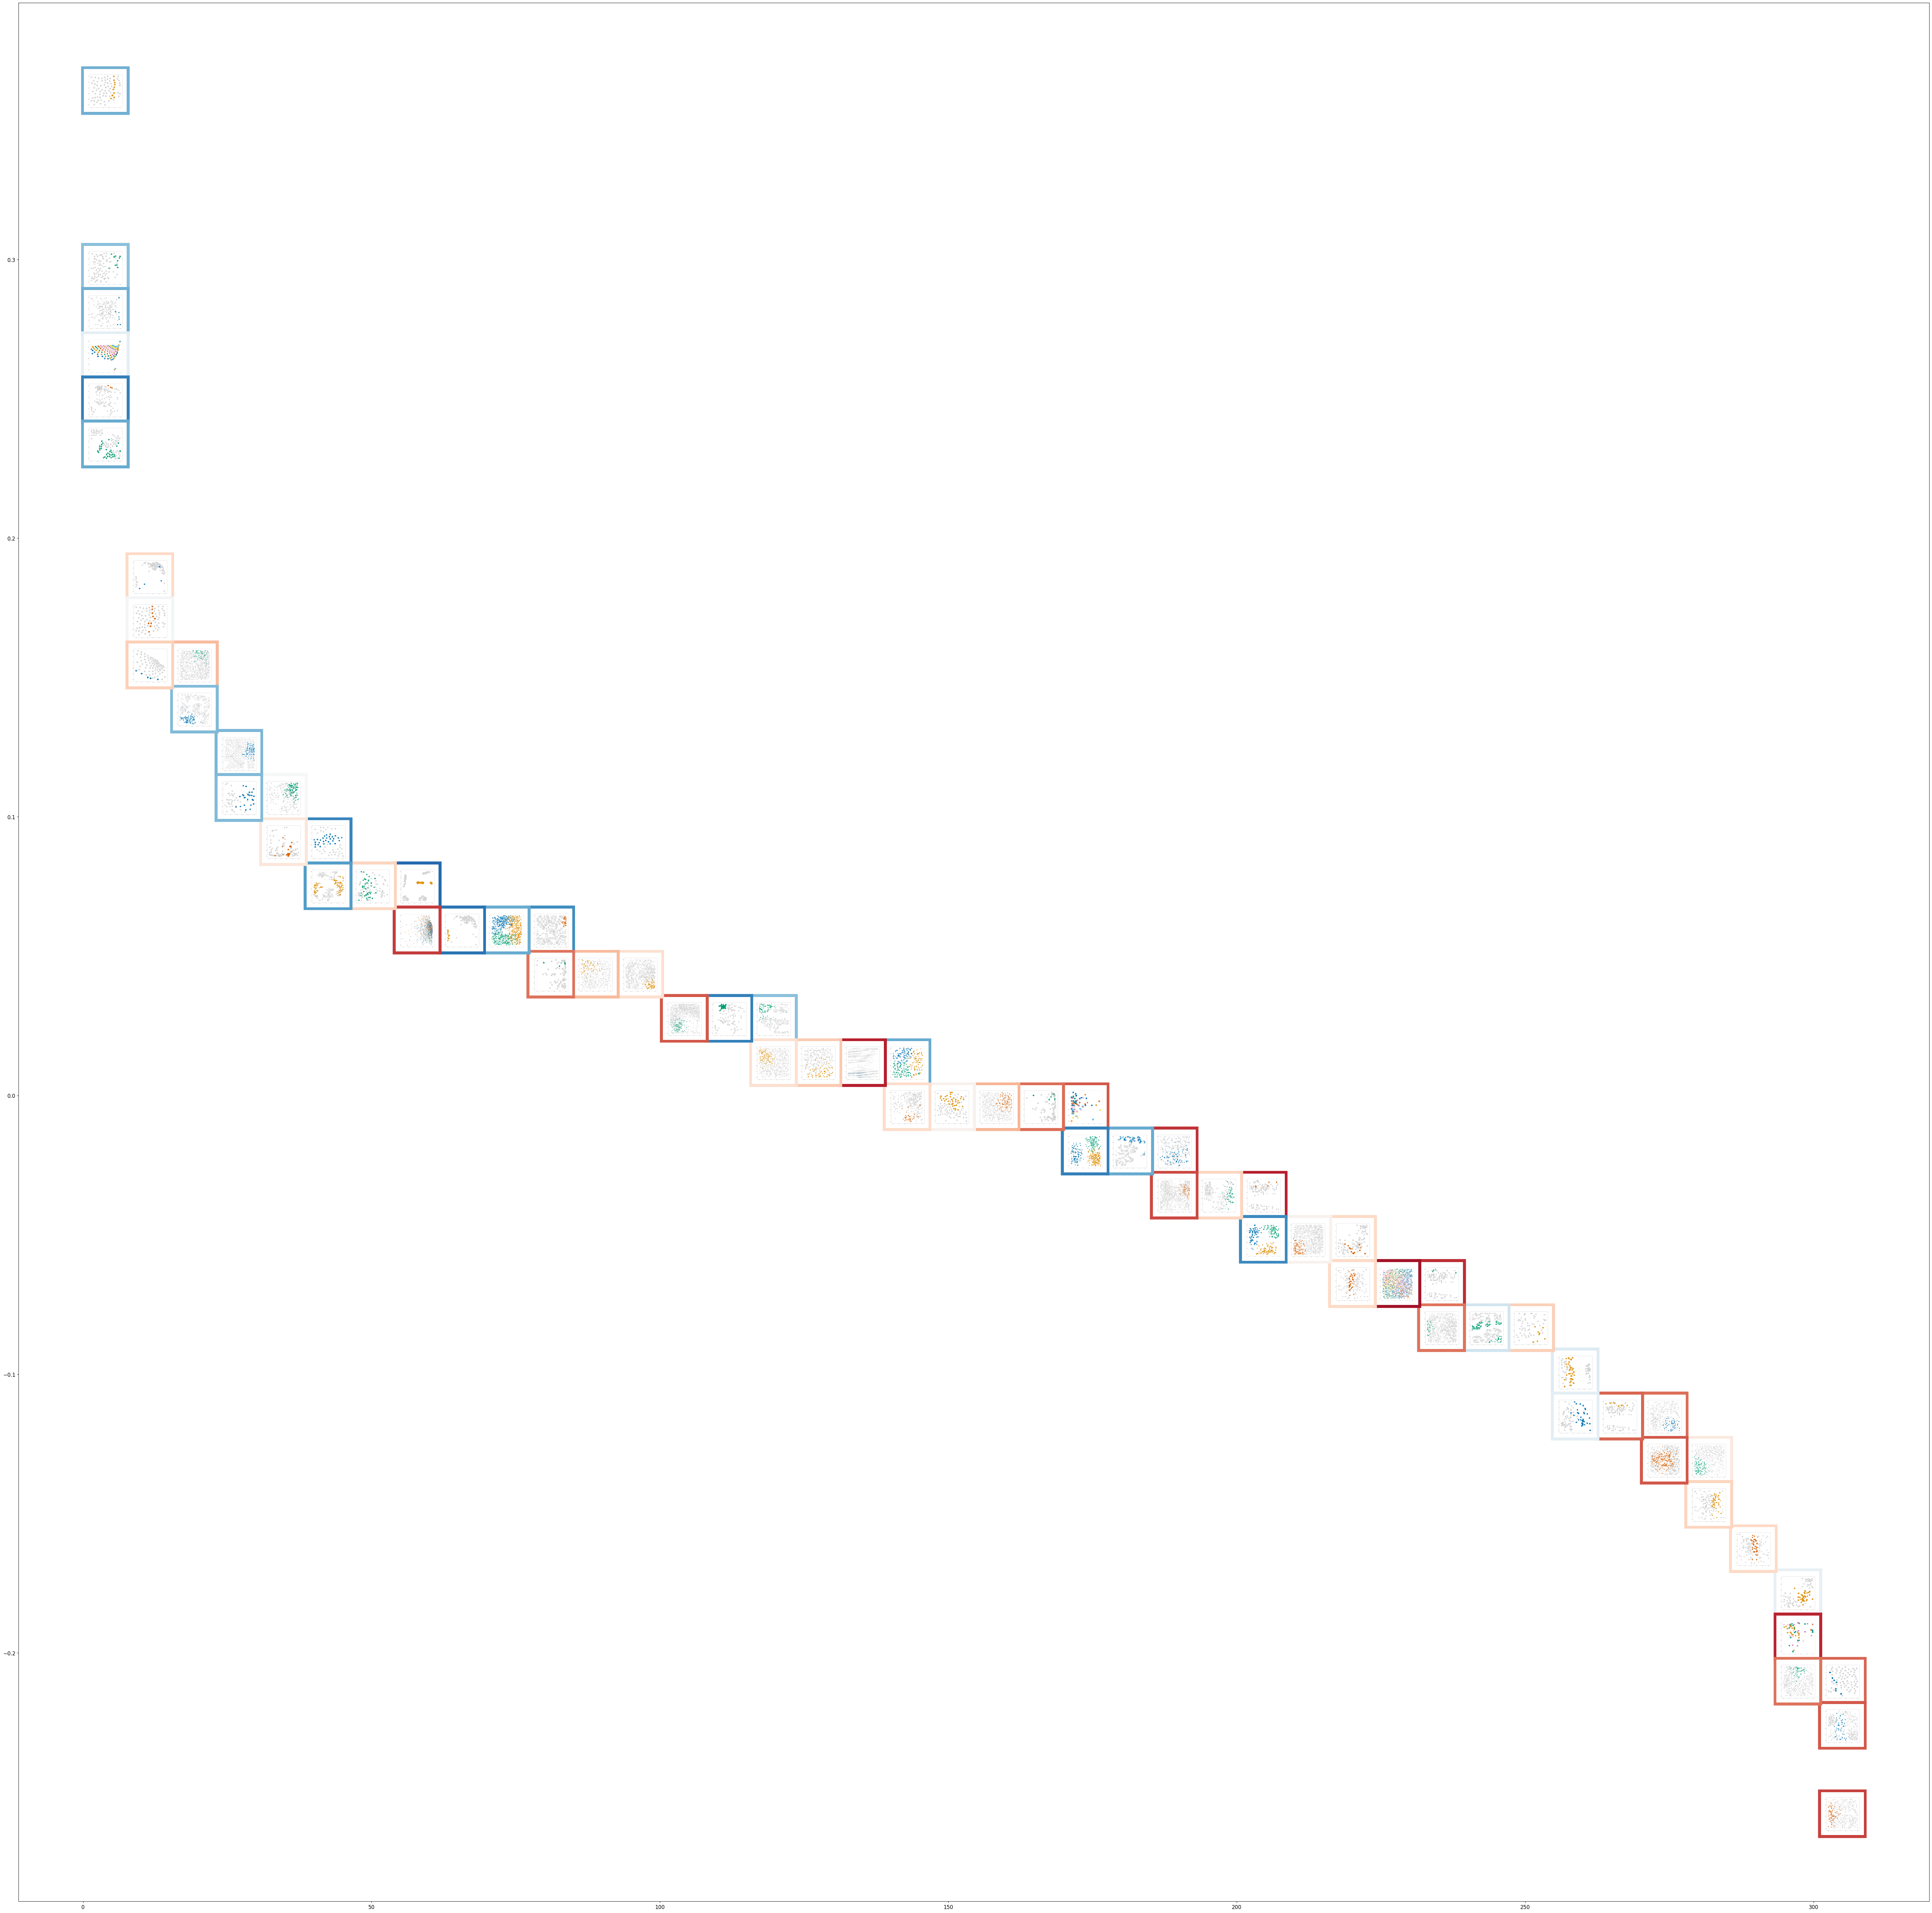

In [191]:
print(df_agg_abs.shape)
customs = pd.read_csv('train_preds_custom.csv')[['filename','type','class','human_rating_mean']]
customs.columns = ['filename','type','class','pred']

df1 = df_agg_abs.merge(customs, on=['filename','type','class'])


df1['MSE'] = df1['human_rating.mean']-df1['pred']
df1['MSE1'] = np.abs(df['MSE'])

df1 = df1.sort_values(['MSE'],ascending=False)
df1 = df1.reset_index(drop=True).reset_index()
df
df1

df1 = grid_scat(df1['index'], df1['MSE'], df1, 
                name ='scatter_MSE_grid_small.pdf',
                hue = 'human_rating.mean',
                figsize=(80,80), 
                size_x=40, size_y=40,n=0,steps = 15)



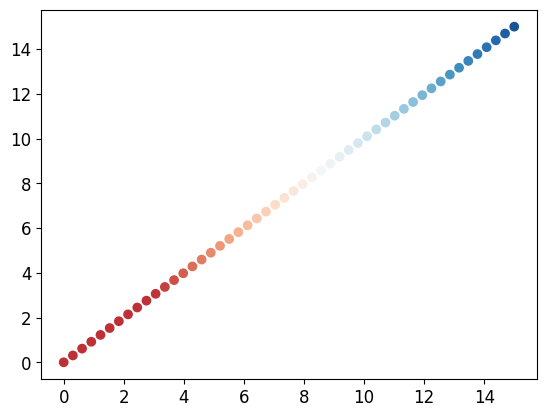

In [181]:
x = np.linspace(0, 15)

mmin = np.round(np.min(df1.spread)*100)
mmax = np.round(np.max(df1.spread)*100)
plt.scatter(x,x, c=plt.cm.RdBu((np.clip(x,mmin,mmax)-1)/15))



In [182]:
mmin

3.0

In [183]:
mmax

22.0